In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.datasets import load_wine

In [2]:
wine=load_wine()

In [3]:
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [4]:
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [5]:
df=pd.DataFrame(wine.data)
df.columns=wine.feature_names
df.columns

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

In [6]:
df['Price']=wine.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Price
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [7]:
import xgboost as xgb

In [8]:
X=wine.data
y=wine.target

In [9]:
data_matrix=xgb.DMatrix(data=X ,label=y)
data_matrix

In [14]:
params = {
    'learning_rate':.1,
    'max_depth':5,
    'alpha':10,
    'booster':'gbtree'
}

In [15]:
result = xgb.cv(dtrain = data_matrix, params=params,num_boost_round=200, early_stopping_rounds=10,metrics='rmse',seed=0 )
result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.834189,0.006406,0.835184,0.016491
1,0.781049,0.002000,0.784806,0.019073
2,0.733035,0.003026,0.740554,0.017019
3,0.689103,0.003335,0.698904,0.016217
4,0.651795,0.002899,0.665532,0.015694
...,...,...,...,...
58,0.243436,0.006132,0.321270,0.008344
59,0.243388,0.006108,0.321242,0.008305
60,0.243019,0.005949,0.320875,0.007787
61,0.242906,0.005909,0.320777,0.007649


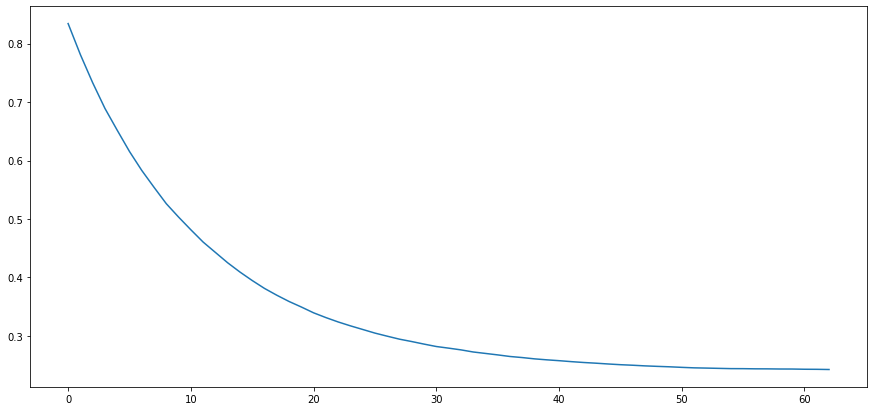

In [16]:
result['train-rmse-mean'].plot(figsize=(15,7))
plt.show()

In [17]:
from tqdm import tqdm

In [19]:
gridsearch_params = [
    (max_depth,learning_rate,alpha,min_child_weight)
    for max_depth in range(3,10)
    for learning_rate in np.arange(.1,1,.05)
    for alpha in range(5,7)
    for min_child_weight in range(6,10)
    
]

In [20]:
len(gridsearch_params)

1008

In [21]:
min_rmse = float('inf')
best_params = None

In [22]:
for max_depth,learning_rate,alpha,min_child_weight in tqdm(gridsearch_params):
    params['max_depth'] = max_depth
    params['learning_rate'] = learning_rate
    params['alpha'] = alpha
    params['min_child_weight'] = min_child_weight
    result = xgb.cv(params=params,
                    dtrain=data_matrix, 
                    num_boost_round=200, 
                    early_stopping_rounds=10, 
                    metrics='rmse',
                    seed = 0)

    mean_rmse = result['test-rmse-mean'].min()
    boost_rounds = result['test-rmse-mean'].argmin()
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,learning_rate,alpha,min_child_weight)

100%|██████████| 1008/1008 [00:47<00:00, 21.28it/s]


In [23]:
print(f"BEST PARAM for Regression {best_params}\n with RMSE {min_rmse:.3f}")

BEST PARAM for Regression (3, 0.25000000000000006, 5, 9)
 with RMSE 0.240


In [24]:
params['max_depth'] = best_params[0]
params['learning_rate'] = best_params[1]
params['alpha'] = best_params[2]
params['min_child_weight'] = best_params[3]

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state=0)
dtrain = xgb.DMatrix(data=xtrain,label=ytrain)
dtest = xgb.DMatrix(data=xtest,label=ytest)

In [29]:
model = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=100,
                  evals=[(dtest,'Test')],
                  early_stopping_rounds=10)

[0]	Test-rmse:0.62618
[1]	Test-rmse:0.52378
[2]	Test-rmse:0.44246
[3]	Test-rmse:0.38093
[4]	Test-rmse:0.35032
[5]	Test-rmse:0.31239
[6]	Test-rmse:0.29914
[7]	Test-rmse:0.27762
[8]	Test-rmse:0.26904
[9]	Test-rmse:0.25774
[10]	Test-rmse:0.24996
[11]	Test-rmse:0.24621
[12]	Test-rmse:0.24144
[13]	Test-rmse:0.24074
[14]	Test-rmse:0.23917
[15]	Test-rmse:0.23848
[16]	Test-rmse:0.23694
[17]	Test-rmse:0.23658
[18]	Test-rmse:0.23599
[19]	Test-rmse:0.23600
[20]	Test-rmse:0.23590
[21]	Test-rmse:0.23537
[22]	Test-rmse:0.23537
[23]	Test-rmse:0.23537
[24]	Test-rmse:0.23537
[25]	Test-rmse:0.23537
[26]	Test-rmse:0.23537
[27]	Test-rmse:0.23537
[28]	Test-rmse:0.23537
[29]	Test-rmse:0.23537
[30]	Test-rmse:0.23537


In [30]:
model.best_iteration

21